** Category Functions **


/Users/rk3570/Desktop/RuleGraph/dataset.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data_list, self.all_data, self.entity2id, self.rel2id = torch.load(self.pr

,relations,num_entities,entities,Category
0,[Sibling_of^(-1)],221,"[2, 3, 4, 5, 6, 9, 10, 11, 12, 15, 16, 17, 24,...",child
1,[Sibling_of],218,"[2, 3, 4, 5, 6, 9, 10, 11, 12, 15, 16, 17, 23,...",child
2,"[Sibling_of, Sibling_of^(-1)]",215,"[2, 3, 4, 5, 6, 9, 10, 11, 12, 15, 16, 17, 27,...",child
3,[Parent_of^(-1)],213,"[2, 3, 4, 5, 6, 9, 10, 11, 12, 15, 16, 17, 20,...",child
4,"[Parent_of^(-1), Sibling_of^(-1)]",203,"[2, 3, 4, 5, 6, 9, 10, 11, 12, 15, 16, 17, 24,...",child
5,"[Sibling_of, Parent_of^(-1)]",202,"[2, 3, 4, 5, 6, 9, 10, 11, 12, 15, 16, 17, 23,...",child
6,"[Sibling_of, Parent_of^(-1), Sibling_of^(-1)]",199,"[2, 3, 4, 5, 6, 9, 10, 11, 12, 15, 16, 17, 27,...",child
7,[Parent_of],100,"[0, 1, 7, 8, 13, 14, 18, 19, 21, 22, 25, 26, 3...",adult


/Users/rk3570/miniconda3/envs/graph/lib/python3.12/site-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'edge_type'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


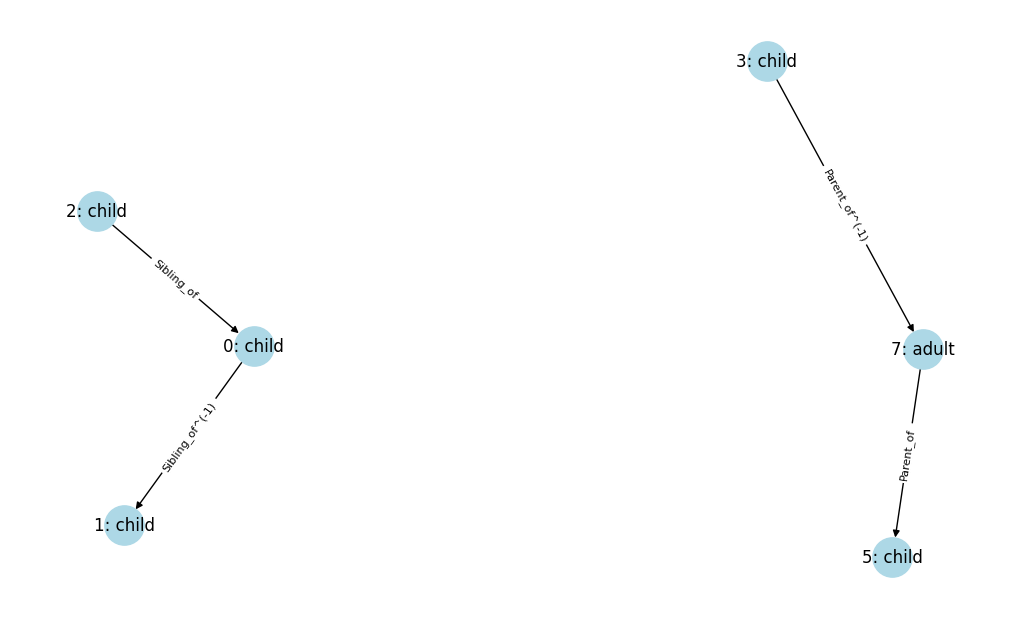

In [3]:
from dataset import build_dataset
import pickle
import os
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

seed = 0

name = "Family"
dataset = build_dataset(name)
dataset.rel2id
id2rel = {}
for k, v in dataset.rel2id.items():
    id2rel[v] = k
processed_dir = dataset.processed_dir
model_path = os.path.join(processed_dir, "model.pkl")

with open(model_path, 'rb') as f:  # open a text file
    model = pickle.load(f)

# Make manual analysis of what the categories mean
def convert_relations(relations):
    return [id2rel[rel] for rel in relations]

model.CF.category_functions['relations'] = model.CF.category_functions['relations'].apply(convert_relations)

def categorize(relations):
    if any('Sibling_of' in rel for rel in relations) or any('Parent_of^(-1)' in rel for rel in relations):
        return 'child'
    else:
        return 'adult'

# Assuming model.CF.category_functions is your DataFrame
model.CF.category_functions['Category'] = model.CF.category_functions['relations'].apply(categorize)
id2category = {}
for index, row in model.CF.category_functions.iterrows():
    id2category[index] = row['Category']

# Display the updated DataFrame
print("** Category Functions **")
display(model.CF.category_functions)

# Create the graph
ruleGraph = to_networkx(model.atomic_rules, edge_attrs=['edge_type'])

# Get the nodes that are present in the edges
edge_index = model.atomic_rules.edge_index.numpy()
nodes = sorted(set(edge_index.flatten()))

# Create a subgraph with only the nodes present in edges
subgraph = ruleGraph.subgraph(nodes)
# Create a layout for the graph
pos = nx.spring_layout(subgraph, seed = seed)

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(subgraph, pos, with_labels=False, node_color='lightblue', node_size=800, arrows=True)

# Add node labels (node IDs)
nx.draw_networkx_labels(subgraph, pos, {node: f"{node}: {id2category[node]}" for node in subgraph.nodes()})

# Add edge labels (relation IDs)
edge_labels = {(u, v): id2rel[d['edge_type']] for u, v, d in subgraph.edges(data=True)}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)

plt.savefig('Family_rule_graph.png')